In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

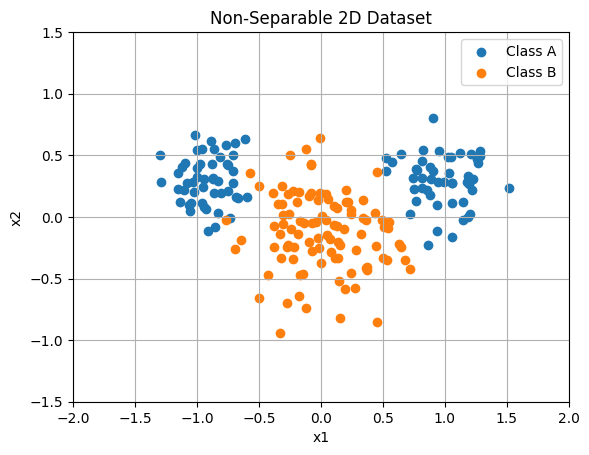

In [2]:
ndata = 100
mA = np.array([1.0, 0.3])
sigmaA = 0.2
mB = np.array([0.0, -0.1])
sigmaB = 0.3

classA_1 = np.concatenate([
    np.random.randn(ndata // 2) * sigmaA - mA[0],
    np.random.randn(ndata // 2) * sigmaA + mA[0]
])
classA_2 = np.random.randn(ndata) * sigmaA + mA[1]

classA = np.vstack([classA_1, classA_2])

classB_1 = np.random.randn(ndata) * sigmaB + mB[0]
classB_2 = np.random.randn(ndata) * sigmaB + mB[1]

classB = np.vstack([classB_1, classB_2])

X = np.hstack([classA, classB])

T_delta = np.hstack([-np.ones(ndata), np.ones(ndata)])
T_perc = np.hstack([np.zeros(ndata), np.ones(ndata)])

perm = np.random.permutation(2 * ndata)
X = X[:, perm]
T_perc = T_perc[perm]
T_delta = T_delta[perm]

plt.figure()
plt.scatter(X[0, T_delta == -1], X[1, T_delta == -1], label="Class A")
plt.scatter(X[0, T_delta == 1], X[1, T_delta == 1], label="Class B")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-2, 2)
plt.ylim(-1.5, 1.5)
plt.title(f"Non-Separable 2D Dataset")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
class BackPropagation:
    def __init__(self, n_input, n_hidden, n_output, eta=0.01, alpha=0.9, decay_rate=0):
        self.eta = eta
        self.decay_rate = decay_rate
        self.alpha = alpha
        self.n_hidden = n_hidden

        self.W = np.random.normal(0, 0.1, (n_hidden, n_input + 1))
        self.V = np.random.normal(0, 0.1, (n_output, n_hidden + 1))

        self.dw = np.zeros(self.W.shape)
        self.dv = np.zeros(self.V.shape)

    def _phi(self, x):
        return (2 / (1 + np.exp(-x))) - 1

    def _phi_prime(self, out):
        return 0.5 * (1 + out) * (1 - out)

    def train(self, X, T, epochs, mse_debug=False):
        n_data = X.shape[1]

        X_with_bias = np.vstack([X, np.ones((1, n_data))])

        self.history = {
            'mse_train': []
        }

        for epoch in range(epochs):
            # Forward Pass
            hin = self.W @ X_with_bias
            hout_raw = self._phi(hin)

            hout = np.vstack([hout_raw, np.ones((1, n_data))])

            oin = self.V @ hout
            out = self._phi(oin)

            # Backward Pass
            delta_o = (out - T) * self._phi_prime(out)

            delta_h_raw = (self.V.T @ delta_o) * self._phi_prime(hout)
            delta_h = delta_h_raw[:self.n_hidden, :]

            # update eta
            self.eta = self.eta / (1 + self.decay_rate * epoch)

            # Update hidden-to-output weights (V)
            self.dv = (self.alpha * self.dv) - (1 - self.alpha) * (delta_o @ hout.T)
            self.V += self.dv * self.eta

            # Update input-to-hidden weights (W)
            self.dw = (self.alpha * self.dw) - (1 - self.alpha) * (delta_h @ X_with_bias.T)
            self.W += self.dw * self.eta

            mse = np.mean(np.square(out - T))
            self.history['mse_train'].append(mse)

            if epoch % 100 == 0 and mse_debug:
                print(f"Epoch {epoch}: MSE = {mse:.6f}")

        print(f"number of hidden nodes = {self.n_hidden}")
        print(f"Final Train MSE = {mse}")

        return self.history

    def batch_train(self, X_train, T_train, X_val, T_val, epochs, mse_debug=False):
      n_train = X_train.shape[1]
      n_val = X_val.shape[1]

      X_train_bias = np.vstack([X_train, np.ones((1, n_train))])
      X_val_bias = np.vstack([X_val, np.ones((1, n_val))])

      self.history = {
          'mse_train': [],
          'mse_val': []
      }

      for epoch in range(epochs):
          # Training forward pass
          hin = self.W @ X_train_bias
          hout_raw = self._phi(hin)
          hout = np.vstack([hout_raw, np.ones((1, n_train))])
          oin = self.V @ hout
          out = self._phi(oin)

          # validation forward pass without backprop
          v_hin = self.W @ X_val_bias
          v_hout = np.vstack([self._phi(v_hin), np.ones((1, n_val))])
          v_out = self._phi(self.V @ v_hout)

          # training backwards pass
          delta_o = (out - T_train) * self._phi_prime(out)
          delta_h_raw = (self.V.T @ delta_o) * self._phi_prime(hout)
          delta_h = delta_h_raw[:self.n_hidden, :]

          # Update weights
          self.dv = (self.alpha * self.dv) - (1 - self.alpha) * (delta_o @ hout.T)
          self.V += self.dv * self.eta

          self.dw = (self.alpha * self.dw) - (1 - self.alpha) * (delta_h @ X_train_bias.T)
          self.W += self.dw * self.eta

          mse_train = np.mean(np.square(out - T_train))
          mse_val = np.mean(np.square(v_out - T_val))

          self.history['mse_train'].append(mse_train)
          self.history['mse_val'].append(mse_val)

          if epoch % 100 == 0 and mse_debug:
              print(f"Epoch {epoch}: Train MSE = {mse_train:.6f} | Val MSE = {mse_val:.6f}")

      print(f"Number of hidden nodes = {self.n_hidden}")
      print(f"Final Train MSE: {self.history['mse_train'][-1]:.6f}")
      print(f"Final Val MSE: {self.history['mse_val'][-1]:.6f}")

      train_acc = self.accuracy(X_train, T_train)
      val_acc = self.accuracy(X_val, T_val)
      print(f"Final Train Accuracy = {train_acc:.6f}%")
      print(f"Final Val Accuracy = {val_acc:.6f}%")

      return self.history

    def sequential_train(self, X_train, T_train, X_val, T_val, epochs, mse_debug=False):
        n_train = X_train.shape[1]
        n_val = X_val.shape[1]

        X_train_bias = np.vstack([X_train, np.ones((1, n_train))])
        X_val_bias = np.vstack([X_val, np.ones((1, n_val))])

        self.history = {
            'mse_train': [],
            'mse_val': []
        }

        for epoch in range(epochs):

            permutation = np.random.permutation(n_train)
            X_train_shuffled = X_train[:, permutation]
            T_train_shuffled = T_train[permutation]

            for i in range(n_train):

                # Select a single sample
                x_sample = X_train_shuffled[:, i].reshape(-1, 1)
                t_sample = T_train_shuffled[i].reshape(1, 1)

                x_sample_bias = np.vstack([x_sample, np.ones((1, 1))])

                # Forward Pass for single sample
                hin_s = self.W @ x_sample_bias
                hout_raw_s = self._phi(hin_s)
                hout_s = np.vstack([hout_raw_s, np.ones((1, 1))])
                oin_s = self.V @ hout_s
                out_s = self._phi(oin_s)

                # Backward Pass for single sample
                delta_o_s = (out_s - t_sample) * self._phi_prime(out_s)
                delta_h_raw_s = (self.V.T @ delta_o_s) * self._phi_prime(hout_s)
                delta_h_s = delta_h_raw_s[:self.n_hidden, :]

                # Update weights
                self.dv = (self.alpha * self.dv) - (1 - self.alpha) * (delta_o_s @ hout_s.T)
                self.V += self.dv * self.eta

                self.dw = (self.alpha * self.dw) - (1 - self.alpha) * (delta_h_s @ x_sample_bias.T)
                self.W += self.dw * self.eta

            # Calculate MSE
            hin = self.W @ X_train_bias
            hout_raw = self._phi(hin)
            hout = np.vstack([hout_raw, np.ones((1, n_train))])
            oin = self.V @ hout
            out = self._phi(oin)

            v_hin = self.W @ X_val_bias
            v_hout = np.vstack([self._phi(v_hin), np.ones((1, n_val))])
            v_out = self._phi(self.V @ v_hout)

            mse_train = np.mean(np.square(out - T_train))
            mse_val = np.mean(np.square(v_out - T_val))

            self.history['mse_train'].append(mse_train)
            self.history['mse_val'].append(mse_val)

            if epoch % 100 == 0 and mse_debug:
                print(f"Epoch {epoch}: Train MSE = {mse_train:.6f} | Val MSE = {mse_val:.6f}")

        print(f"Number of hidden nodes = {self.n_hidden}")
        print(f"Final Train MSE: {self.history['mse_train'][-1]:.6f}")
        print(f"Final Val MSE: {self.history['mse_val'][-1]:.6f}")

        train_acc = self.accuracy(X_train, T_train)
        val_acc = self.accuracy(X_val, T_val)
        print(f"Final Train Accuracy = {train_acc:.6f}%")
        print(f"Final Val Accuracy = {val_acc:.6f}%")

        return self.history


    def accuracy(self, X, T):
        out = self.predict(X)
        preds = np.where(out >= 0, 1, -1)

        correct_hits = np.sum(preds == T)
        acc = (correct_hits / T.size) * 100
        return acc

    def predict(self, X):
        n_data = X.shape[1]
        X_with_bias = np.vstack([X, np.ones((1, n_data))])

        hout_raw = self._phi(self.W @ X_with_bias)
        hout = np.vstack([hout_raw, np.ones((1, n_data))])
        return self._phi(self.V @ hout)

    def plot_decision_boundary(self, X, T):
      x1_min, x1_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
      x2_min, x2_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5

      xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 150),
                             np.linspace(x2_min, x2_max, 150))

      grid_points = np.vstack([xx.ravel(), yy.ravel()])
      Z = self.predict(grid_points)
      Z = Z.reshape(xx.shape)

      plt.figure(figsize=(10, 7))

      contour = plt.contourf(xx, yy, Z, levels=50, cmap='RdBu_r', alpha=0.6)
      cbar = plt.colorbar(contour)
      cbar.set_label('Network Output (Blue: -1, Red: +1)')

      boundary = plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
      plt.clabel(boundary, inline=True, fontsize=12, fmt={0: 'Boundary (0)'})

      targets = T.flatten()

      plt.scatter(X[0, targets == -1], X[1, targets == -1],
                  c='blue', edgecolors='k', s=40, label="Class A (-1)")

      plt.scatter(X[0, targets == 1], X[1, targets == 1],
                  c='red', edgecolors='k', s=40, label="Class B (1)")

      plt.xlim(x1_min, x1_max)
      plt.ylim(x2_min, x2_max)

      plt.title(f"Backprop Decision Boundary")
      plt.xlabel("x1")
      plt.ylabel("x2")
      plt.axhline(0, color='black', lw=1, alpha=0.2)
      plt.axvline(0, color='black', lw=1, alpha=0.2)
      plt.legend(loc='upper right')
      plt.grid(True, alpha=0.2)
      plt.show()



In [4]:
for n in range(1, 15):
  nn = BackPropagation(n_input=2, n_hidden=n, n_output=1, eta=0.05, alpha=0.9)
  nn.train(X, T_delta, epochs=5000)

number of hidden nodes = 1
Final Train MSE = 0.5551228580572054
number of hidden nodes = 2
Final Train MSE = 0.5535851067543474
number of hidden nodes = 3
Final Train MSE = 0.02638010335046138
number of hidden nodes = 4
Final Train MSE = 0.026218420708468217
number of hidden nodes = 5
Final Train MSE = 0.021854223428508946
number of hidden nodes = 6
Final Train MSE = 0.02238791703379379
number of hidden nodes = 7
Final Train MSE = 0.02668785481065767
number of hidden nodes = 8
Final Train MSE = 0.01848706107799962
number of hidden nodes = 9
Final Train MSE = 0.02480158586654416
number of hidden nodes = 10
Final Train MSE = 0.022021708117961242
number of hidden nodes = 11
Final Train MSE = 0.02522138551998876
number of hidden nodes = 12
Final Train MSE = 0.024365648617487645
number of hidden nodes = 13
Final Train MSE = 0.012772998784576748
number of hidden nodes = 14
Final Train MSE = 0.024003402927843132


In [5]:
import numpy as np

def apply_sampling_scenario(X, T_delta, scenario):

    idx_A = np.where(T_delta == -1)[0]
    idx_B = np.where(T_delta == 1)[0]

    train_idx_A = []
    train_idx_B = []

    match scenario:
        case 1:
            train_idx_A = np.random.choice(idx_A, size=int(0.25 * len(idx_A)), replace=False)
            train_idx_B = np.random.choice(idx_B, size=int(0.25 * len(idx_B)), replace=False)

        case 2:
            train_idx_A = np.random.choice(idx_A, size=int(0.50 * len(idx_A)), replace=False)
            train_idx_B = idx_B

        case 3:
            mask_neg = (X[0, idx_A] < 0)
            mask_pos = (X[0, idx_A] >= 0)

            sub_idx_neg = idx_A[mask_neg]
            sub_idx_pos = idx_A[mask_pos]

            keep_neg = np.random.choice(sub_idx_neg, size=int(0.2 * len(sub_idx_neg)), replace=False)
            keep_pos = np.random.choice(sub_idx_pos, size=int(0.8 * len(sub_idx_pos)), replace=False)

            train_idx_A = np.concatenate([keep_neg, keep_pos])
            train_idx_B = idx_B

    train_indices = np.concatenate([train_idx_A, train_idx_B])

    all_indices = np.arange(X.shape[1])
    val_indices = np.setdiff1d(all_indices, train_indices)

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    X_train, T_train = X[:, train_indices], T_delta[train_indices]
    X_val, T_val = X[:, val_indices], T_delta[val_indices]

    return X_train, T_train, X_val, T_val

Number of hidden nodes = 5
Final Train MSE: 0.001154
Final Val MSE: 0.059633
Final Train Accuracy = 100.000000%
Final Val Accuracy = 98.666667%


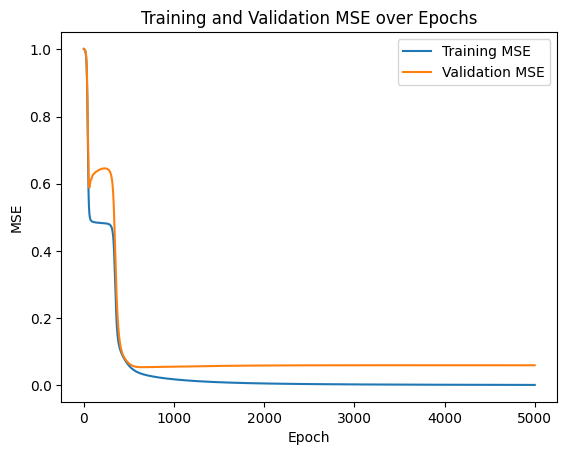

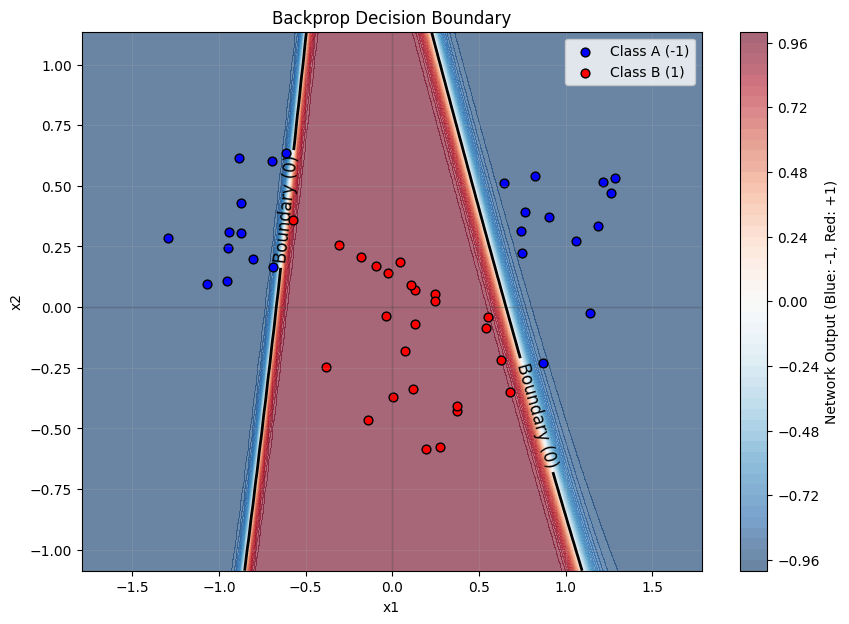

Number of hidden nodes = 5
Final Train MSE: 0.001145
Final Val MSE: 0.059421
Final Train Accuracy = 100.000000%
Final Val Accuracy = 98.666667%


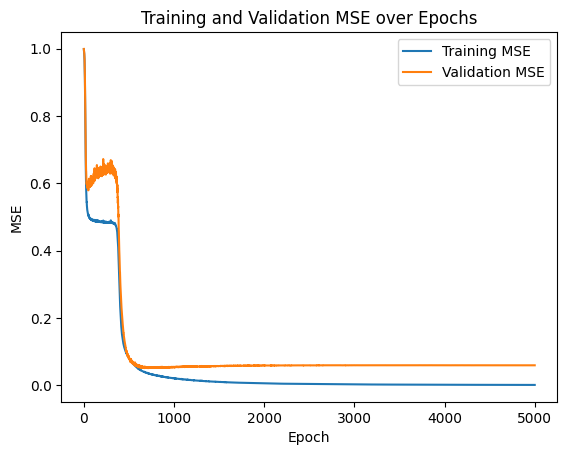

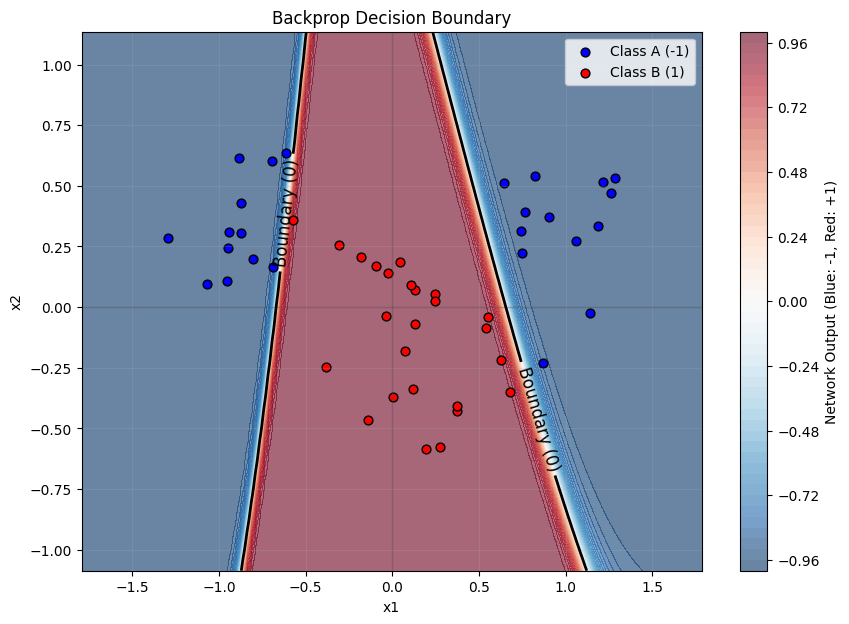

In [6]:
X_train, T_train, X_val, T_val = apply_sampling_scenario(X, T_delta, scenario=1)
nn1 = BackPropagation(n_input=2, n_hidden=5, n_output=1, eta=0.05, alpha=0.9)
batch_history = nn1.batch_train(X_train, T_train, X_val, T_val, epochs=5000)

plt.figure()
plt.plot(batch_history['mse_train'], label='Training MSE')
plt.plot(batch_history['mse_val'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE over Epochs')
plt.legend()
plt.show()
nn1.plot_decision_boundary(X_train, T_train)

nn2 = BackPropagation(n_input=2, n_hidden=5, n_output=1, eta=0.05, alpha=0.9)
sequential_history = nn2.sequential_train(X_train, T_train, X_val, T_val, epochs=5000)

plt.figure()
plt.plot(sequential_history['mse_train'], label='Training MSE')
plt.plot(sequential_history['mse_val'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE over Epochs')
plt.legend()
plt.show()
nn2.plot_decision_boundary(X_train, T_train)

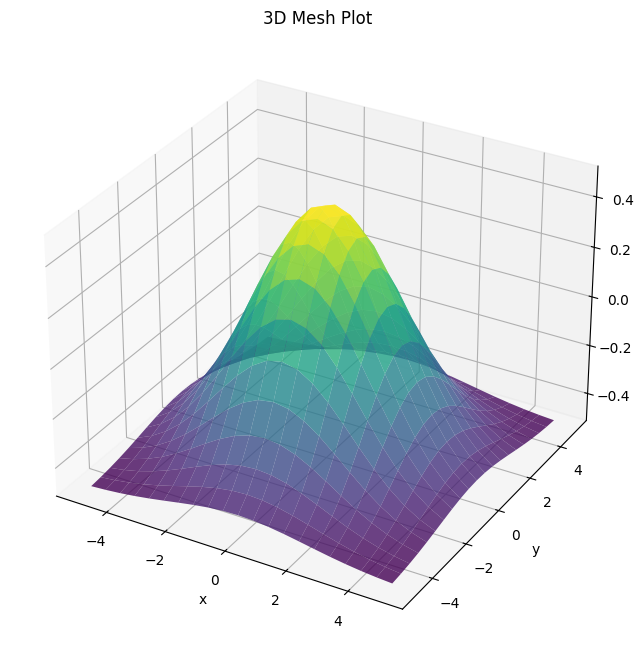

In [7]:
x = np.arange(-5, 5.1, 0.5)
y = np.arange(-5, 5.1, 0.5)

X, Y = np.meshgrid(x, y)

Z = np.exp(-(X**2) * 0.1) * np.exp(-(Y**2) * 0.1) - 0.5

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D Mesh Plot')

plt.show()

In [8]:
ndata = X.size

targets = Z.reshape(1, ndata)

patterns = np.vstack([X.reshape(1, ndata), Y.reshape(1, ndata)])

number of hidden nodes = 15
Final Train MSE = 0.0002156281384326258


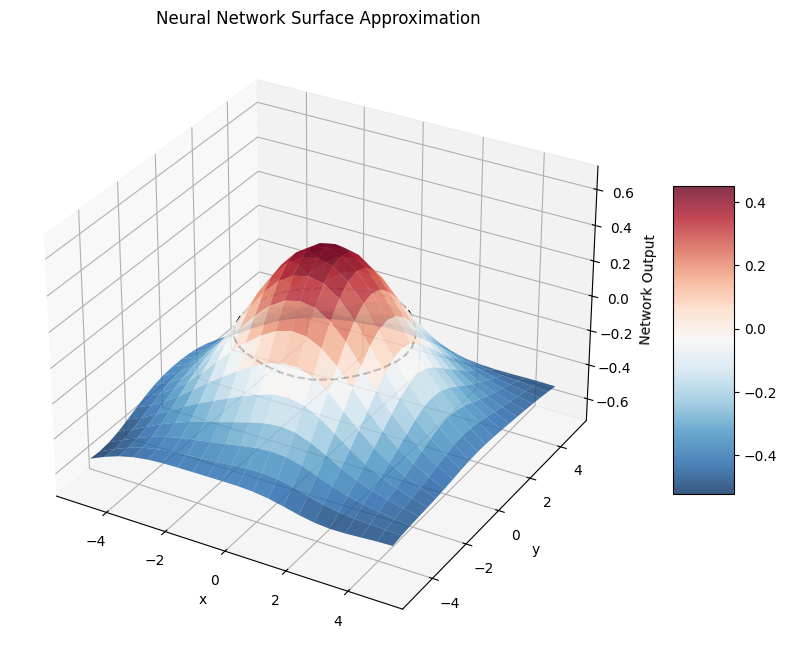

In [9]:
nn_3d = BackPropagation(n_input=2, n_hidden=15, n_output=1, eta=0.01, alpha=0.9)
nn_3d.train(patterns, targets, epochs=5000)

out = nn_3d.predict(patterns)
zz = out.reshape(X.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, zz, cmap='RdBu_r', edgecolor='none', alpha=0.8)


ax.contour(X, Y, zz, levels=[0], colors='black', linestyles='dashed')

ax.set_zlim(-0.7, 0.7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Network Output')
ax.set_title('Neural Network Surface Approximation')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [10]:
patterns = np.vstack([X.reshape(1, ndata), Y.reshape(1, ndata)])
targets = Z.reshape(1, ndata)

perm = np.random.permutation(ndata)

shuffled_patterns = patterns[:, perm]
shuffled_targets = targets[:, perm]

In [11]:
nsamp = 50
patterns_train = shuffled_patterns[:, :nsamp]
targets_train = shuffled_targets[:, :nsamp]

number of hidden nodes = 15
Final Train MSE = 0.001483446205732689
Generalization MSE (nsamp=50): 0.002394


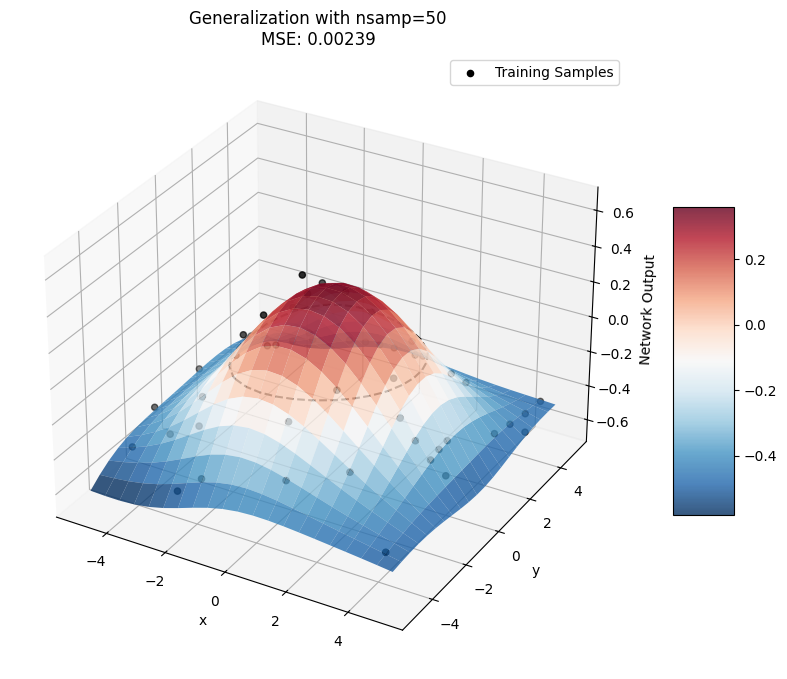

In [12]:
nn_3d = BackPropagation(n_input=2, n_hidden=15, n_output=1, eta=0.01, alpha=0.9)
nn_3d.train(patterns_train, targets_train, epochs=5000)

out = nn_3d.predict(patterns)
zz = out.reshape(X.shape)

mse = np.mean(np.square(out - targets))
print(f"Generalization MSE (nsamp={nsamp}): {mse:.6f}")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, zz, cmap='RdBu_r', edgecolor='none', alpha=0.8)
ax.contour(X, Y, zz, levels=[0], colors='black', linestyles='dashed')

train_x = patterns_train[0, :]
train_y = patterns_train[1, :]
train_z = targets_train[0, :]
ax.scatter(train_x, train_y, train_z, color='black', s=20, label='Training Samples')
ax.set_zlim(-0.7, 0.7)
ax.set_title(f'Generalization with nsamp={nsamp}\nMSE: {mse:.5f}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Network Output')
ax.legend()

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [13]:
best_mse = np.inf
best_model = None

nsamp = 100
patterns_train = shuffled_patterns[:, :nsamp]
targets_train = shuffled_targets[:, :nsamp]

for hidden_nodes in range(1, 26):
  nn_3d = BackPropagation(n_input=2, n_hidden=hidden_nodes, n_output=1, eta=0.01, alpha=0.9)
  nn_3d.train(patterns_train, targets_train, epochs=5000)

  out = nn_3d.predict(patterns)
  zz = out.reshape(X.shape)

  mse = np.mean(np.square(out - targets))
  print(f"Generalization MSE (nsamp={nsamp}): {mse:.6f}\n")

  if mse < best_mse:
    best_mse = mse
    best_model = nn_3d

number of hidden nodes = 1
Final Train MSE = 0.0543088351560067
Generalization MSE (nsamp=100): 0.062223

number of hidden nodes = 2
Final Train MSE = 0.037504685858711556
Generalization MSE (nsamp=100): 0.040451

number of hidden nodes = 3
Final Train MSE = 0.0014310739137386277
Generalization MSE (nsamp=100): 0.003721

number of hidden nodes = 4
Final Train MSE = 0.0013892601693151784
Generalization MSE (nsamp=100): 0.003524

number of hidden nodes = 5
Final Train MSE = 0.0015224742306196356
Generalization MSE (nsamp=100): 0.002389

number of hidden nodes = 6
Final Train MSE = 0.0013131445106323097
Generalization MSE (nsamp=100): 0.003391

number of hidden nodes = 7
Final Train MSE = 0.0002178760560991089
Generalization MSE (nsamp=100): 0.000589

number of hidden nodes = 8
Final Train MSE = 0.001480985986871086
Generalization MSE (nsamp=100): 0.002374

number of hidden nodes = 9
Final Train MSE = 0.0009142088222422004
Generalization MSE (nsamp=100): 0.002326

number of hidden nodes =

In [14]:
percentages = [0.8, 0.6, 0.4, 0.2]
results = []

for p in percentages:
    nsamp = int(ndata * p)

    patterns_train = shuffled_patterns[:, :nsamp]
    targets_train = shuffled_targets[:, :nsamp]

    model = BackPropagation(n_input=2, n_hidden=best_model.n_hidden, n_output=1, eta=0.01, alpha=0.9)

    model.train(patterns_train, targets_train, epochs=5000)

    out = model.predict(patterns)
    mse = np.mean(np.square(out - targets))

    results.append((p, nsamp, mse))
    print(f"Results for {int(p*100)}% data ({nsamp} samples):")
    print(f"  Generalization MSE: {mse:.6f}\n")

number of hidden nodes = 22
Final Train MSE = 0.00015970605726828185
Results for 80% data (352 samples):
  Generalization MSE: 0.000180

number of hidden nodes = 22
Final Train MSE = 0.00012128511953490998
Results for 60% data (264 samples):
  Generalization MSE: 0.000146

number of hidden nodes = 22
Final Train MSE = 0.0009609070359076034
Results for 40% data (176 samples):
  Generalization MSE: 0.001365

number of hidden nodes = 22
Final Train MSE = 0.00022891354677181242
Results for 20% data (88 samples):
  Generalization MSE: 0.000924



number of hidden nodes = 22
Final Train MSE = 0.0003750238944139861
number of hidden nodes = 22
Final Train MSE = 0.00016248892116062894


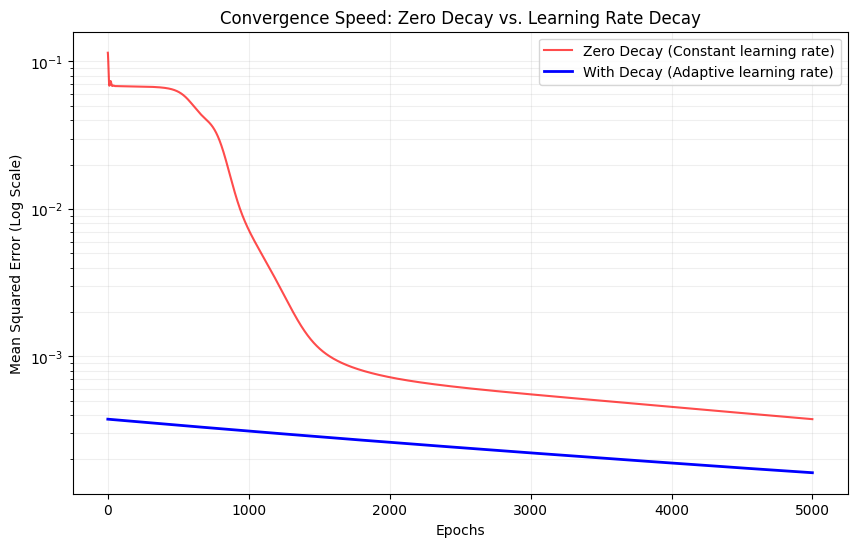

In [15]:
model_no_decay = BackPropagation(n_input=2, n_hidden=best_model.n_hidden, n_output=1, eta=0.01, alpha=0.9)
history_no_decay = model_no_decay.train(patterns_train, targets_train, epochs=5000)

model_with_decay = BackPropagation(n_input=2, n_hidden=best_model.n_hidden, n_output=1, eta=0.01, alpha=0.9, decay_rate=0.001)
history_with_decay = model_no_decay.train(patterns_train, targets_train, epochs=5000)

plt.figure(figsize=(10, 6))
plt.plot(history_no_decay['mse_train'], label='Zero Decay (Constant learning rate)', color='red', alpha=0.7)
plt.plot(history_with_decay['mse_train'], label='With Decay (Adaptive learning rate)', color='blue', lw=2)

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Log Scale)')
plt.title('Convergence Speed: Zero Decay vs. Learning Rate Decay')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Part 2

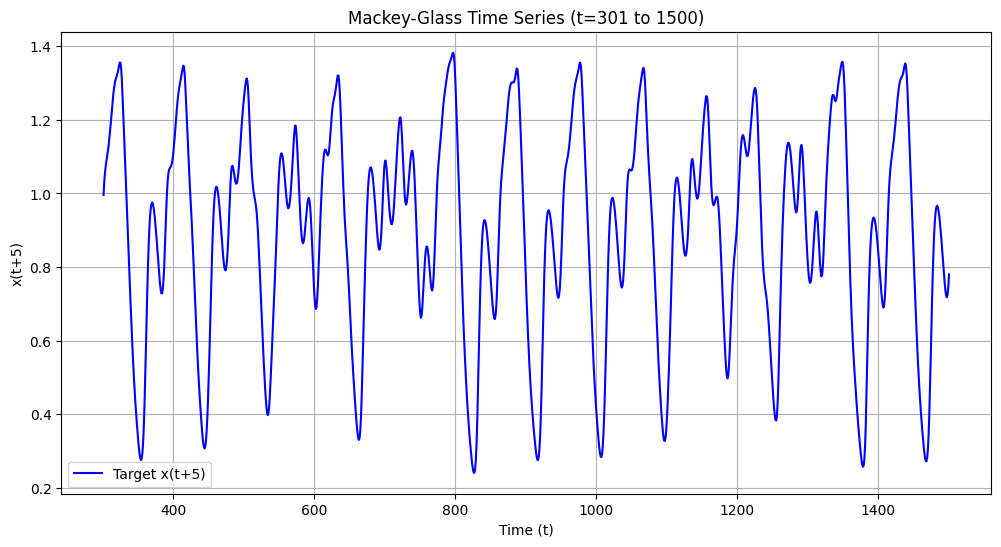

Data shapes
Train: (800, 5), Val: (200, 5), Test: (200, 5)
X_train: (800, 5), y_train: (800, 1)
X_val:   (200, 5), y_val:   (200, 1)
X_test:  (200, 5), y_test:  (200, 1)


In [19]:
def generate_macket_glass(maximum = 1505):
    x = np.zeros(maximum + 1)
    x[0] = 1.5

    for t in range(0, maximum):
        if (t- 25) >= 0:
            x_delayed = x[t - 25]
        else:
            x_delayed = 0

        x[t + 1] = x[t] + (0.2 * x_delayed) / (1 + x_delayed ** 10) - 0.1 * x[t]
    return x

full_series = generate_macket_glass(1505)

t_eval = np.arange(301, 1501)
inputs = []
targets = []

for t in t_eval:
    current_input = [full_series[t - 20], full_series[t - 15], full_series[t - 10], full_series[t - 5], full_series[t]]
    inputs.append(current_input)
    targets.append(full_series[t + 5])

inputs = np.array(inputs)
targets = np.array(targets)

plt.figure(figsize=(12, 6))
plt.plot(t_eval, targets.flatten(), label='Target x(t+5)', color='blue')
plt.title('Mackey-Glass Time Series (t=301 to 1500)')
plt.xlabel('Time (t)')
plt.ylabel('x(t+5)')
plt.legend()
plt.grid(True)
plt.show()

# Data splitting

n_total = inputs.shape[0]
n_test = 200
n_val = 200
n_train = n_total - n_val - n_test

X_train, y_train = inputs[:n_train], targets[:n_train].reshape(-1, 1)
X_val, y_val = inputs[n_train:n_train+n_val], targets[n_train:n_train + n_val].reshape(-1, 1)
X_test, y_test = inputs[n_total-n_test:], targets[n_total-n_test:].reshape(-1, 1)

print(f"Data shapes")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

In [20]:
class BackPropagationPart2:
    def __init__(self, n_input, n_h1, n_h2, n_output, eta=0.01, alpha=0.9, lambd=0.001):
        self.n_input = n_input
        self.n_h1 = n_h1
        self.n_h2 = n_h2
        self.n_output = n_output
        self.eta = eta
        self.alpha = alpha
        self.lambd = lambd
        
        self.W1 = np.random.normal(0, 0.1, (n_h1, n_input + 1))
        self.W2 = np.random.normal(0, 0.1, (n_h2, n_h1 + 1))
        self.V = np.random.normal(0, 0.1, (n_output, n_h2 + 1))
        
        self.dw1 = np.zeros_like(self.W1)
        self.dw2 = np.zeros_like(self.W2)
        self.dv = np.zeros_like(self.V)

    def phi(self, x):
        return (2 / (1 + np.exp(-x))) - 1

    def phi_prime(self, output):
        return 0.5 * (1 + output) * (1 - output)

    def forward(self, X):
        self.X = np.vstack([X.T, np.ones((1, X.shape[0]))])
        
        self.h1_in = self.W1 @ self.X
        self.h1_out = self.phi(self.h1_in)
        self.h1_out_bias = np.vstack([self.h1_out, np.ones((1, self.h1_out.shape[1]))])
        
        self.h2_in = self.W2 @ self.h1_out_bias
        self.h2_out = self.phi(self.h2_in)
        self.h2_out_bias = np.vstack([self.h2_out, np.ones((1, self.h2_out.shape[1]))])
        
        self.o_in = self.V @ self.h2_out_bias
        self.o_out = self.o_in 
        return self.o_out.T

    def backward(self, targets):
        T = targets.T
        
        delta_o = (self.o_out - T)
        
        delta_h2 = (self.V[:, :-1].T @ delta_o) * self.phi_prime(self.h2_out)
        
        delta_h1 = (self.W2[:, :-1].T @ delta_h2) * self.phi_prime(self.h1_out)
        
        self.dw1 = self.alpha * self.dw1 - (1 - self.alpha) * (delta_h1 @ self.X.T)
        self.dw2 = self.alpha * self.dw2 - (1 - self.alpha) * (delta_h2 @ self.h1_out_bias.T)
        self.dv = self.alpha * self.dv - (1 - self.alpha) * (delta_o @ self.h2_out_bias.T)
        
        self.W1 = self.W1 + self.eta * self.dw1 - self.eta * self.lambd * self.W1
        self.W2 = self.W2 + self.eta * self.dw2 - self.eta * self.lambd * self.W2
        self.V = self.V + self.eta * self.dv - self.eta * self.lambd * self.V

    def train(self, X_train, y_train, X_val, y_val, epochs=5000, patience=50):
        history = {'mse_train': [], 'mse_val': []}
        best_val_error = float('inf')
        patience_counter = 0
        best_weights = None

        for epoch in range(epochs):
            self.forward(X_train)
            self.backward(y_train)
            
            train_preds = self.forward(X_train)
            mse_train = np.mean((train_preds - y_train)**2)
            history['mse_train'].append(mse_train)
            
            val_preds = self.forward(X_val)
            mse_val = np.mean((val_preds - y_val)**2)
            history['mse_val'].append(mse_val)
            
            if mse_val < best_val_error:
                best_val_error = mse_val
                patience_counter = 0
                best_weights = (self.W1.copy(), self.W2.copy(), self.V.copy())
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                self.W1, self.W2, self.V = best_weights
                break
                
        return history

Hidden Layer 1: 3, Hidden Layer 2: 2 => Final Val MSE: 0.010356
Hidden Layer 1: 3, Hidden Layer 2: 4 => Final Val MSE: 0.010399
Hidden Layer 1: 3, Hidden Layer 2: 6 => Final Val MSE: 0.010453
Hidden Layer 1: 4, Hidden Layer 2: 2 => Final Val MSE: 0.010138
Hidden Layer 1: 4, Hidden Layer 2: 4 => Final Val MSE: 0.010520
Hidden Layer 1: 4, Hidden Layer 2: 6 => Final Val MSE: 0.010330
Hidden Layer 1: 5, Hidden Layer 2: 2 => Final Val MSE: 0.010041
Hidden Layer 1: 5, Hidden Layer 2: 4 => Final Val MSE: 0.010461
Hidden Layer 1: 5, Hidden Layer 2: 6 => Final Val MSE: 0.010498

Best Model: Hidden Layer 1: 5, Hidden Layer 2: 2 => Val MSE: 0.010041
Worst Model: Hidden Layer 1: 4, Hidden Layer 2: 4 => Val MSE: 0.010520

Best Model Robustness: Mean Val MSE: 0.009039, Std Dev: 0.002927
Worst Model Robustness: Mean Val MSE: 0.008954, Std Dev: 0.002781


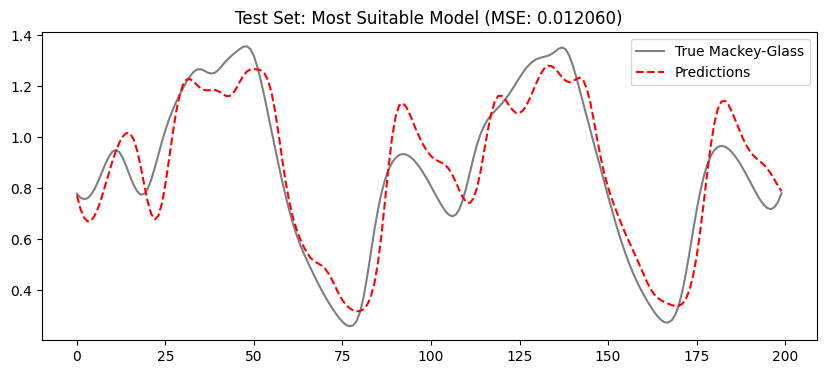

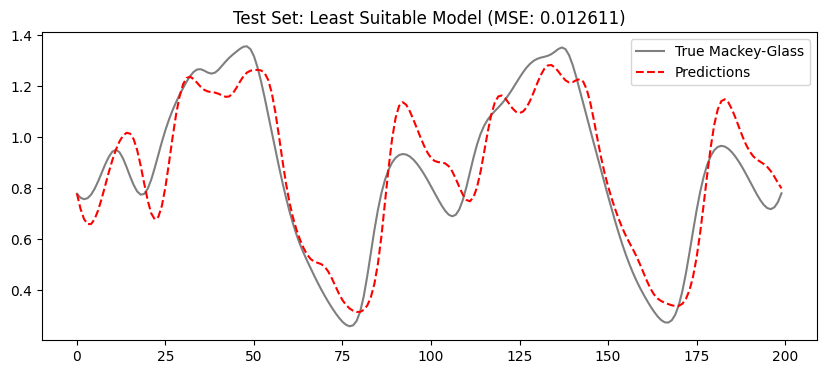

In [21]:
n_h1_options = [3, 4, 5]
n_h2_options = [2, 4, 6]

results = []

for h1 in n_h1_options:
    for h2 in n_h2_options:
        model = BackPropagationPart2(n_input=5, n_h1=h1, n_h2=h2, n_output=1, eta=0.01, alpha=0.9, lambd=0.001)

        history = model.train(X_train, y_train, X_val, y_val, epochs=2000, patience=100)

        final_val_mse = history['mse_val'][-1]
        results.append((h1, h2, final_val_mse))
        print(f"Hidden Layer 1: {h1}, Hidden Layer 2: {h2} => Final Val MSE: {final_val_mse:.6f}")

results.sort(key=lambda x: x[2])
best_h1, best_h2, best_mse = results[0]
worst_h1, worst_h2, worst_mse = results[-1]

print(f"\nBest Model: Hidden Layer 1: {best_h1}, Hidden Layer 2: {best_h2} => Val MSE: {best_mse:.6f}")
print(f"Worst Model: Hidden Layer 1: {worst_h1}, Hidden Layer 2: {worst_h2} => Val MSE: {worst_mse:.6f}")

def test_robustness(h1, h2, n_runs = 5):
    mse_list = []
    for _ in range(n_runs):
        m = BackPropagationPart2(n_input=5, n_h1=h1, n_h2=h2, n_output=1, eta=0.01, alpha=0.9, lambd=0.001)
        h = m.train(X_train, y_train, X_val, y_val, epochs=1000, patience=100)
        mse_list.append(h['mse_val'][-1])
    return np.mean(mse_list), np.std(mse_list)

b_mean, b_std = test_robustness(best_h1, best_h2)
w_mean, w_std = test_robustness(worst_h1, worst_h2)

print(f"\nBest Model Robustness: Mean Val MSE: {b_mean:.6f}, Std Dev: {b_std:.6f}")
print(f"Worst Model Robustness: Mean Val MSE: {w_mean:.6f}, Std Dev: {w_std:.6f}")

def plot_test_results(h1, h2, label):
    model = BackPropagationPart2(n_input=5, n_h1=h1, n_h2=h2, n_output=1, eta=0.01, alpha=0.9, lambd=0.001)
    model.train(X_train, y_train, X_val, y_val, epochs=1000, patience=100)
    preds = model.forward(X_test)
    mse = np.mean((preds - y_test)**2)
    
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label="True Mackey-Glass", color='black', alpha=0.5)
    plt.plot(preds, label="Predictions", color='red', linestyle='--')
    plt.title(f"Test Set: {label} (MSE: {mse:.6f})")
    plt.legend()
    plt.show()

plot_test_results(best_h1, best_h2, "Most Suitable Model")
plot_test_results(worst_h1, worst_h2, "Least Suitable Model")

In [ ]:
def add_noise(data, sigma):
    return data + np.random.normal(0, sigma, data.shape)

sigmas = [0.05, 0.15]
n_h2_variants = [3, 6, 9]
lambdas = [0.0, 0.01, 0.001]

noise_results = []

for sigma in sigmas:
    y_train_noisy = add_noise(y_train, sigma)

    for h2 in n_h2_variants:
        for lambd in lambdas:
            model = BackPropagationPart2(n_input=5, n_h1=best_h1, n_h2=h2, n_output=1, eta=0.01, alpha=0.9, lambd=lambd)
            history = model.train(X_train, y_train_noisy, X_val, y_val, epochs=2000, patience=100)
            final_val_mse = history['mse_val'][-1]
            noise_results.append((sigma, h2, lambd, final_val_mse))
            
            print(f"Sigma: {sigma}, Hidden Layer 2: {h2}, Lambda: {lambd} => Final Value MSE: {final_val_mse:.6f}")



Sigma: 0.05, Hidden Layer 2: 3, Lambda: 0.0 => Final Value MSE: 0.010661
Sigma: 0.05, Hidden Layer 2: 3, Lambda: 0.01 => Final Value MSE: 0.010580
Sigma: 0.05, Hidden Layer 2: 3, Lambda: 0.001 => Final Value MSE: 0.010440
Sigma: 0.05, Hidden Layer 2: 6, Lambda: 0.0 => Final Value MSE: 0.010067
Sigma: 0.05, Hidden Layer 2: 6, Lambda: 0.01 => Final Value MSE: 0.003275
Sigma: 0.05, Hidden Layer 2: 6, Lambda: 0.001 => Final Value MSE: 0.010785
Sigma: 0.05, Hidden Layer 2: 9, Lambda: 0.0 => Final Value MSE: 0.010356
Sigma: 0.05, Hidden Layer 2: 9, Lambda: 0.01 => Final Value MSE: 0.010515
Sigma: 0.05, Hidden Layer 2: 9, Lambda: 0.001 => Final Value MSE: 0.010753
Sigma: 0.15, Hidden Layer 2: 3, Lambda: 0.0 => Final Value MSE: 0.004394
Sigma: 0.15, Hidden Layer 2: 3, Lambda: 0.01 => Final Value MSE: 0.004536
Sigma: 0.15, Hidden Layer 2: 3, Lambda: 0.001 => Final Value MSE: 0.002764
Sigma: 0.15, Hidden Layer 2: 6, Lambda: 0.0 => Final Value MSE: 0.011344
Sigma: 0.15, Hidden Layer 2: 6, Lambda: